### Amazon SageMaker Asynchronous Inference
_**A new near real-time Inference option for generating machine learning model predictions**_

**Table of Contents**

* [Background](#background)
* [Notebook Scope](#scope)
* [Overview and sample end to end flow](#overview)
* [Section 1 - Setup](#setup) 
    * [Create Model](#createmodel)
    * [Create EndpointConfig](#endpoint-config)
    * [Create Endpoint](#create-endpoint)
    * [Setup AutoScaling policy (Optional)](#setup-autoscaling)
* [Section 2 - Using the Endpoint](#endpoint) 
    * [Invoke Endpoint](#invoke-endpoint)
    * [Check Output Location](#check-output)
    * [Multiple Invocations](#multiple-invoke)  
* [Section 3 - Clean up](#clean)

### Background <a id='background'></a>  
Amazon SageMaker Asynchronous Inference is a new capability in SageMaker that queues incoming requests and processes them asynchronously. SageMaker currently offers two inference options for customers to deploy machine learning models: 1) a real-time option for low-latency workloads 2) Batch transform, an offline option to process inference requests on batches of data available upfront. Real-time inference is suited for workloads with payload sizes of less than 6 MB and require inference requests to be processed within 60 seconds. Batch transform is suitable for offline inference on batches of data. 

Asynchronous inference is a new inference option for near real-time inference needs. Requests can take up to 15 minutes to process and have payload sizes of up to 1 GB. Asynchronous inference is suitable for workloads that do not have sub-second latency requirements and have relaxed latency requirements. For example, you might need to process an inference on a large image of several MBs within 5 minutes. In addition, asynchronous inference endpoints let you control costs by scaling down endpoints instance count to zero when they are idle, so you only pay when your endpoints are processing requests. 

### Notebook scope <a id='scope'></a>  
This notebook provides an introduction to the SageMaker Asynchronous inference capability. This notebook will cover the steps required to create an asynchonous inference endpoint and test it with some sample requests. 

### Overview and sample end to end flow <a id='overview'></a>
Asynchronous inference endpoints have many similarities (and some key differences) compared to real-time endpoints. The process to create asynchronous endpoints is similar to real-time endpoints. You need to create: a model, an endpoint configuration, and then an endpoint. However, there are specific configuration parameters specific to asynchronous inference endpoints which we will explore below. 

Invocation of asynchronous endpoints differ from real-time endpoints. Rather than pass request payload inline with the request, you upload the payload to Amazon S3 and pass an Amazon S3 URI as a part of the request. Upon receiving the request, SageMaker provides you with a token with the output location where the result will be placed once processed. Internally, SageMaker maintains a queue with these requests and processes them. During endpoint creation, you can optionally specify an Amazon SNS topic to receive success or error notifications. Once you receive the notification that your inference request has been successfully processed, you can access the result in the output Amazon S3 location. 

The diagram below provides a visual overview of the end-to-end flow with Asynchronous inference endpoint.

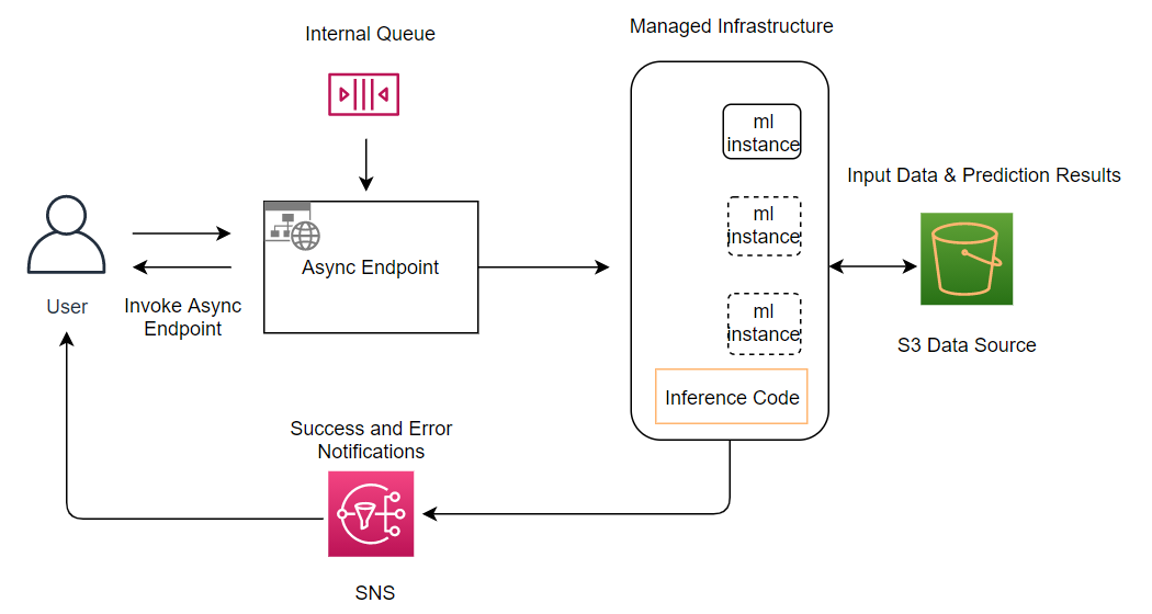

---
## 1. Setup <a id='setup'></a>

First we ensure we have an updated version of boto3, which includes the latest SageMaker features:

Import the required python libraries:

In [ ]:
!python -m pip install --upgrade pip --quiet
!pip install -U awscli --quiet

In [ ]:
import sagemaker
import boto3
from time import gmtime, strftime

sm_session = sagemaker.session.Session()
sm_client = boto3.client("sagemaker")
sm_runtime = boto3.client("sagemaker-runtime")
boto_session = boto3.session.Session()
region = boto_session.region_name

Specify your IAM role. Go the AWS IAM console (https://console.aws.amazon.com/iam/home) and add the following policies to your IAM Role:
* SageMakerFullAccessPolicy
* Amazon S3 access: Apply this to get and put objects in your Amazon S3 bucket. Replace `bucket_name` with the name of your Amazon S3 bucket:      

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject",
                "s3:CancelMultipartUpload",
                "s3:ListBuckets"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:s3:::bucket_name/*"
        }
    ]
}
```

* (Optional) Amazon SNS access: Add `sns:Publish` on the topics you define. Apply this if you plan to use Amazon SNS to receive notifications.

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "sns:Publish"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:sns:us-east-2:123456789012:MyTopic"
        }
    ]
}
```

* (Optional) KMS decrypt, encrypt if your Amazon S3 bucket is encrypte.

Specify your SageMaker IAM Role (`sm_role`) and Amazon S3 bucket (`s3_bucket`). You can optionally use a default SageMaker Session IAM Role and Amazon S3 bucket. Make sure the role you use has the necessary permissions for SageMaker, Amazon S3, and optionally Amazon SNS.

In [ ]:
sm_role = sagemaker.get_execution_role()
# Feel free to use your own role here
# sm_role = "arn:aws:iam::123456789012:role/sagemaker-custom-role"
sm_role = "arn:aws:iam::757967535041:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole"
print(f"Using Role: {sm_role}")
s3_bucket = sm_session.default_bucket()
print(f"Will use bucket '{s3_bucket}' for storing all resources related to this notebook")

In [ ]:
bucket_prefix = "async-inference-demo"
resource_name = "AsyncInferenceDemo"

Next, you will create a model with `CreateModel`, an endpoint configuration with `CreateEndpointConfig`, and then an endpoint with the `CreateEndpoint` API.


### 1.1 Create Model <a id='createmodel'></a>
Specify the location of the pre-trained model stored in Amazon S3. This example uses a pre-trained XGBoost model name demo-xgboost-model.tar.gz. The full Amazon S3 URI is stored in a string variable `model_url`. 

In [ ]:
model_s3_key = f"{bucket_prefix}/demo-xgboost-model.tar.gz"
model_url = f"s3://{s3_bucket}/{model_s3_key}"
print(f"Uploading Model to {model_url}")
with open("demo-xgboost-model.tar.gz", "rb") as model_file:
    boto3.Session().resource("s3").Bucket(s3_bucket).Object(model_s3_key).upload_fileobj(model_file)

Specify a primary container. For the primary container, you specify the Docker image that contains inference code, artifacts (from prior training), and a custom environment map that the inference code uses when you deploy the model for predictions. In this example, we specify an XGBoost built-in algorithm container image.

In [ ]:
from sagemaker import image_uris

# Specify an AWS container image and region as desired
container = image_uris.retrieve(region=region, framework="xgboost", version="0.90-1")

Create a model by specifying the `ModelName`, the `ExecutionRoleARN` (the ARN of the IAM role that Amazon SageMaker can assume to access model artifacts/ docker images for deployment), and the `PrimaryContainer`.

In [ ]:
model_name = resource_name.format("Model")
create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=sm_role,
    PrimaryContainer={
        "Image": container,
        "ModelDataUrl": model_url,
    },
)

print(f"Created Model: {create_model_response['ModelArn']}")

### 1.2 Create EndpointConfig <a id='endpointconfig'></a>

Once you have a model, create an endpoint configuration with `CreateEndpointConfig`. Amazon SageMaker hosting services uses this configuration to deploy models. In the configuration, you identify one or more model that were created using with `CreateModel` API, to deploy the resources that you want Amazon SageMaker to provision. Specify the `AsyncInferenceConfig` object and provide an output Amazon S3 location for `OutputConfig`. You can optionally specify Amazon SNS topics on which to send notifications about prediction results.

In [ ]:
endpoint_config_name = resource_name.format("EndpointConfig")
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{s3_bucket}/{bucket_prefix}/output",
            # Optionally specify Amazon SNS topics
            # "NotificationConfig": {
            #   "SuccessTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
            #   "ErrorTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
            # }
        },
        "ClientConfig": {"MaxConcurrentInvocationsPerInstance": 4},
    },
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

### 1.3 Create Endpoint <a id='create-endpoint'></a>

Once you have your model and endpoint configuration, use the `CreateEndpoint` API to create your endpoint. The endpoint name must be unique within an AWS Region in your AWS account.

In [ ]:
endpoint_name = resource_name.format("Endpoint")
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Validate that the endpoint is created before invoking it:

In [ ]:
waiter = boto3.client("sagemaker").get_waiter("endpoint_in_service")
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

### 1.4 Setup AutoScaling policy (Optional)    <a id='setup-autoscaling'></a>

This section describes how to configure autoscaling on your asynchronous endpoint using Application Autoscaling. You need to first register your endpoint variant with Application Autoscaling, define a scaling policy, and then apply the scaling policy. In this configuration, we use a custom metric, `CustomizedMetricSpecification`, called `ApproximateBacklogSizePerInstance`. Please refer to the SageMaker Developer guide for a detailed list of metrics available with your asynchronous inference endpoint.

In [ ]:
client = boto3.client(
    "application-autoscaling"
)  # Common class representing Application Auto Scaling for SageMaker amongst other services

resource_id = (
    "endpoint/" + endpoint_name + "/variant/" + "variant1"
)  # This is the format in which application autoscaling references the endpoint

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=0,
    MaxCapacity=5,
)

response = client.put_scaling_policy(
    PolicyName="Invocations-ScalingPolicy",
    ServiceNamespace="sagemaker",  # The namespace of the AWS service that provides the resource.
    ResourceId=resource_id,  # Endpoint name
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="TargetTrackingScaling",  # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 5.0,  # The target value for the metric. - here the metric is - SageMakerVariantInvocationsPerInstance
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 600,  # The cooldown period helps you prevent your Auto Scaling group from launching or terminating
        # additional instances before the effects of previous activities are visible.
        # You can configure the length of time based on your instance startup time or other application needs.
        # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start.
        "ScaleOutCooldown": 300  # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled.
        # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    },
)

The endpoint is now ready for invocation.

--- 
## 2. Using the Endpoint <a id='endpoint'></a>

### 2.1 Uploading the Request Payload <a id='upload'></a>

First, you need to upload the request to Amazon S3. We define a function called, `upload_file`, to make it easier to make multiple invocations in a later step.

In [ ]:
import os


def upload_file(input_location):
    prefix = f"{bucket_prefix}/input"
    return sm_session.upload_data(
        input_location,
        bucket=sm_session.default_bucket(),
        key_prefix=prefix,
        extra_args={"ContentType": "text/libsvm"},
    )

In [ ]:
input_1_location = "input/test_point_0.libsvm"
input_1_s3_location = upload_file(input_1_location)

### 2.1 Invoke Endpoint   <a id='invoke-endpoint'></a>

Get inferences from the model hosted at your asynchronous endpoint with `InvokeEndpointAsync`. Specify the location of your inference data in the `InputLocation` field and the name of your endpoint for `EndpointName`. The response payload contains the output Amazon S3 location where the result will be placed. 

In [ ]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, InputLocation=input_1_s3_location
)
output_location = response["OutputLocation"]
print(f"OutputLocation: {output_location}")

### 2.2 Check Output Location <a id='check-output'></a>

Check the output location to see if the inference has been processed. We make multiple requests (beginning of the `while True` statement in the `get_output` function) every two seconds until there is an output of the inference request: 

In [ ]:
import urllib, time
from botocore.exceptions import ClientError


def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sm_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response["Error"]["Code"] == "NoSuchKey":
                print("waiting for output...")
                time.sleep(2)
                continue
            raise

In [ ]:
output = get_output(output_location)
print(f"Output: {output}")

### 2.3 Multiple Invocations  <a id='multiple-invoke'></a>

The following shows how you can invoke the endpoint with multiple requests:

In [ ]:
inferences = []
for i in range(25):
    input_file = f"input/test_point_{i}.libsvm"
    input_file_s3_location = upload_file(input_file)
    print(f"Invoking Endpoint with {input_file}")
    response = sm_runtime.invoke_endpoint_async(
        EndpointName=endpoint_name, InputLocation=input_file_s3_location
    )
    output_location = response["OutputLocation"]
    inferences += [(input_file, output_location)]
    time.sleep(0.5)

for input_file, output_location in inferences:
    output = get_output(output_location)
    print(f"Input File: {input_file}, Output: {output}")

### 3. Clean up <a id='clean'></a>

Remember to delete your endpoint after use as you will be charged for the instances used in this Demo. 

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)

You may also want to delete any other resources you might have created such as SNS topics, S3 objects, etc.